https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning


In [1]:
import os
print(os.getcwd())

/Users/brah/anaconda3/envs/Pennylane_test


In [2]:
### SET DIRECTORY
import os
os.chdir("/Users/brah/anaconda3/envs/Pennylane_test") # my directory
print(os.getcwd())

/Users/brah/anaconda3/envs/Pennylane_test


In [3]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

In [4]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 3              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer


In [5]:
dev = qml.device("default.qubit", wires=n_qubits)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
print(device)

cpu


In [8]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [9]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [10]:
q_weights_flat=np.random.rand(24)
q_input_features=np.random.rand(4)

In [94]:
print(qml.draw(quantum_net)(q_input_features,q_weights_flat))

0: ──H──RY(0.52)─╭●──RY(0.01)───────────╭●──RY(0.77)───────────╭●──RY(0.86)───────────╭●──RY(0.31)
1: ──H──RY(0.43)─╰X─╭●─────────RY(0.82)─╰X─╭●─────────RY(0.07)─╰X─╭●─────────RY(0.62)─╰X─╭●───────
2: ──H──RY(0.03)─╭●─╰X─────────RY(0.71)─╭●─╰X─────────RY(0.36)─╭●─╰X─────────RY(0.33)─╭●─╰X───────
3: ──H──RY(0.11)─╰X──RY(0.73)───────────╰X──RY(0.12)───────────╰X──RY(0.06)───────────╰X──RY(0.64)

────────────╭●──RY(0.89)───────────╭●──RY(0.76)───────────┤  <Z>
───RY(0.33)─╰X─╭●─────────RY(0.47)─╰X─╭●─────────RY(0.56)─┤  <Z>
───RY(0.73)─╭●─╰X─────────RY(0.12)─╭●─╰X─────────RY(0.77)─┤  <Z>
────────────╰X──RY(0.71)───────────╰X──RY(0.49)───────────┤  <Z>


/var/folders/rz/_zrzz9sd5jg_sxkrlcmb9q_w0000gp/T/ipykernel_1402/3282972552.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


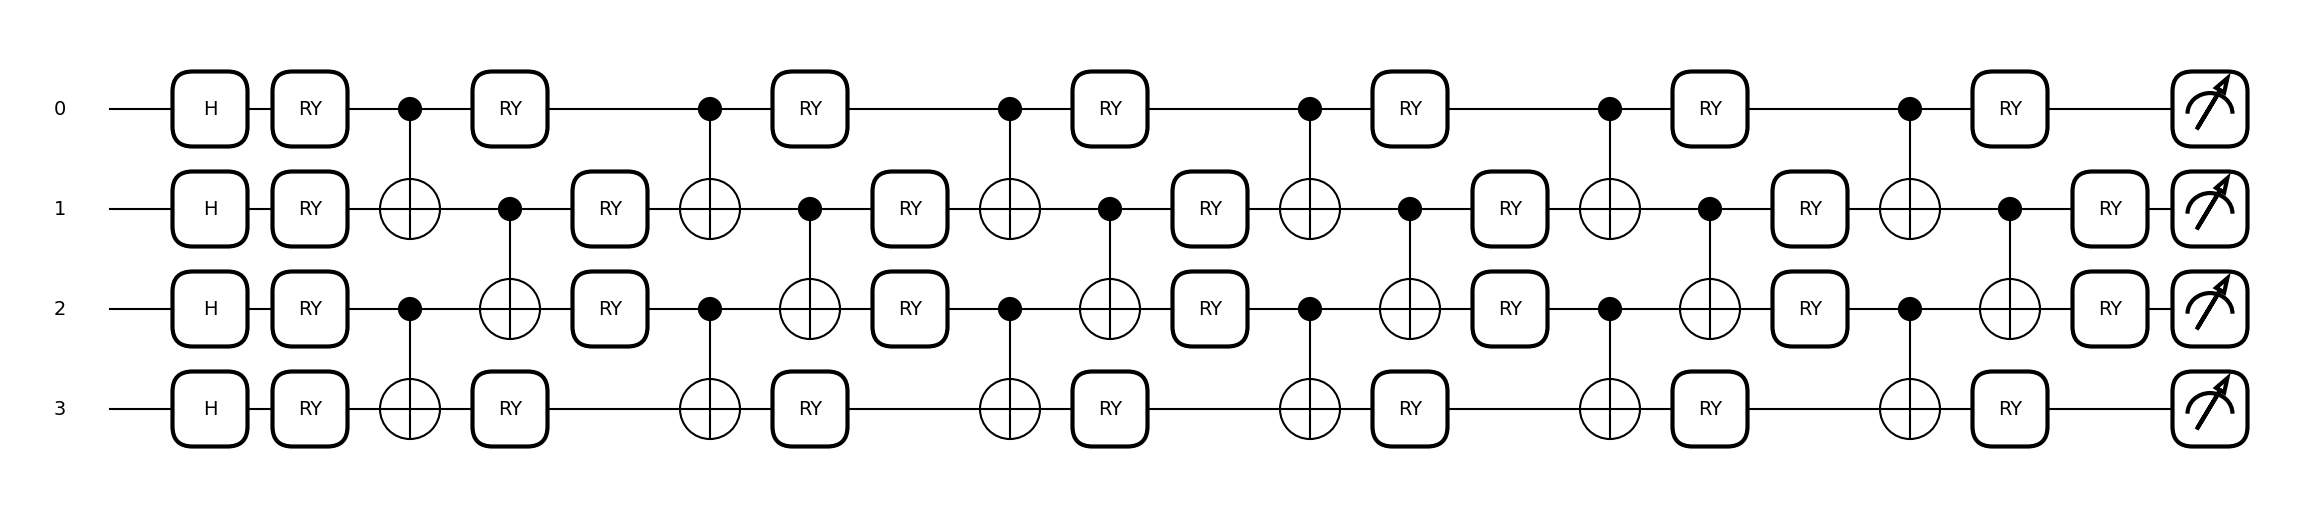

In [11]:
fig, ax=qml.draw_mpl(quantum_net)(q_input_features,q_weights_flat)
fig.show()